# Load Libraries

In [1]:
# basic
import os
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

work_dir = '/lustre/work/akira.tokiwa/LensingSSC'

sys.path.append(work_dir+'/lib')
sys.path.append(work_dir+'/src')

In [2]:
from astropy import cosmology
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

# Initialize cosmology model
chi = 5000
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.309)
z = cosmology.z_at_value(cosmo.comoving_distance, chi * u.Mpc).value
print(z)

1.7980456025637581


In [3]:
from src.masssheet.ConfigData import ConfigData, CatalogHandler
config_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_data.json')
config = ConfigData.from_json(config_file)
cath_tiled = CatalogHandler(config.tileddir, config.source, config.dataset)
cath_bigbox = CatalogHandler(config.bigboxdir, config.source, config.dataset)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


# Kappa maps

In [4]:
# load base kappa
path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/data/kappa_zs0.5.fits'

# read the data
kappa_nested = hp.read_map(path) # in nested ordering
kappa = hp.reorder(kappa_nested, n2r=True) # convert to ring ordering

In [8]:
smoothed_path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/smoothed/kappa_zs0.5_smoothed_s10.fits'

# read the smoothed map
kappa_smoothed = hp.read_map(smoothed_path)
kappa_smoothed_nested = hp.reorder(kappa_smoothed, r2n=True)

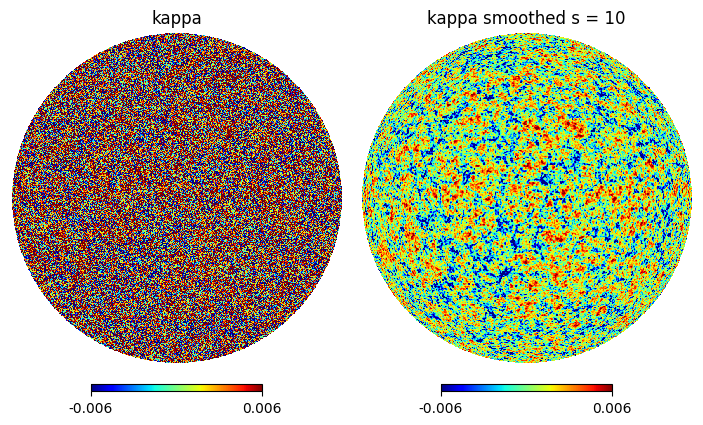

In [9]:
# plot the data
fig = plt.figure(figsize=(7, 4))
hp.orthview(kappa, title='kappa', sub=(1, 2, 1), min=-0.006, max=0.006, cmap='jet', half_sky=True)
hp.orthview(kappa_smoothed, title='kappa smoothed s = 10', sub=(1, 2, 2), min=-0.006, max=0.006, cmap='jet', half_sky=True)
plt.show()

In [27]:
nside = hp.get_nside(kappa)
base_pix = 2048 ** 2
pix_offset = 5 * nside ** 2

start_idx = pix_offset
end_idx = pix_offset + base_pix

In [ ]:
patch = kappa[start_idx:end_idx]
for i in range(10):
    start_idx = pix_offset + i * base_pix
    end_idx = pix_offset + (i + 1) * base_pix
    print(f'start_idx: {start_idx}, end_idx: {end_idx}')
    print(f'kappa[start_idx:end_idx]: {kappa[start_idx:end_idx]}')
    print(f'kappa_smoothed[start_idx:end_idx]: {kappa_smoothed[start_idx:end_idx]}')

In [ ]:
def patch_fig(patch, start_idx, end_idx, nside, lmax=1000):
    # make an array has the same size as the original map
    patch_full = np.zeros(hp.nside2npix(nside))
    patch_full[start_idx:end_idx] = patch
    patch_full = hp.ma(patch_full)
    patch_full.mask = np.zeros(patch_full.size, dtype=bool)
    patch_full.mask[:start_idx] = True
    patch_full.mask[end_idx:] = True

    fig = plt.figure(figsize=(7, 4))
    hp.mollview(patch_full, title='kappa smoothed s = 10', sub=(1, 1, 1), min=-0.006, max=0.006, cmap='jet', nest=True)
    plt.show()
    plt.close()

In [28]:
def patch_power(patch, start_idx, end_idx, nside, lmax=1000):
    # make an array has the same size as the original map
    patch_full = np.zeros(hp.nside2npix(nside))
    patch_full[start_idx:end_idx] = patch
    patch_full = hp.ma(patch_full)
    patch_full.mask = np.zeros(patch_full.size, dtype=bool)
    patch_full.mask[:start_idx] = True
    patch_full.mask[end_idx:] = True

    fig = plt.figure(figsize=(7, 4))
    hp.mollview(patch_full, title='kappa smoothed s = 10', sub=(1, 1, 1), min=-0.006, max=0.006, cmap='jet', nest=True)
    plt.show()
    plt.close()
    
    cl = hp.anafast(patch_full.filled(), lmax=lmax)
    ell = np.arange(cl.size)
    return ell, cl

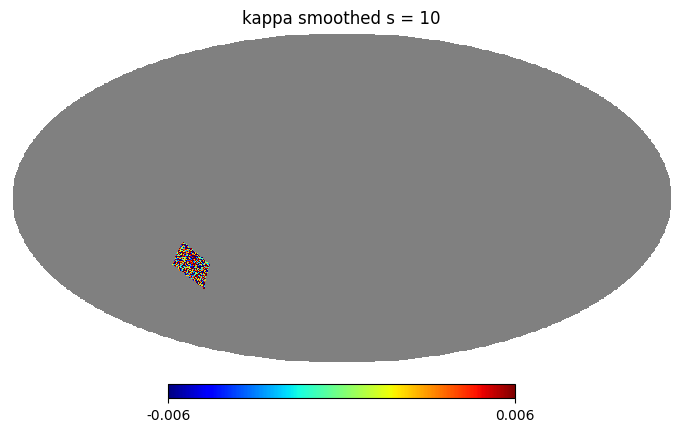

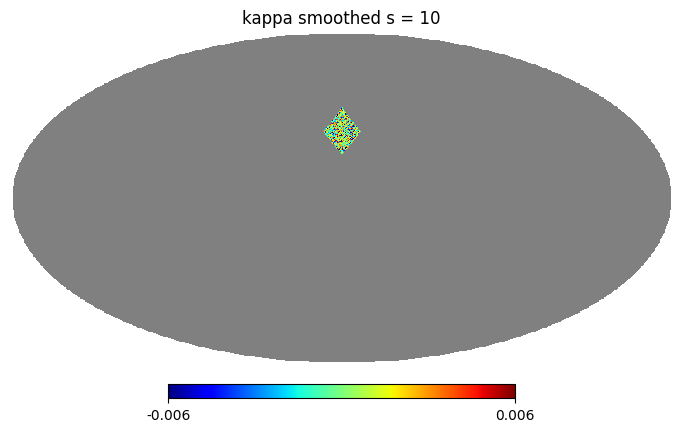

KeyboardInterrupt: 

In [29]:
ell, cl = patch_power(kappa[start_idx:end_idx], start_idx, end_idx, nside)

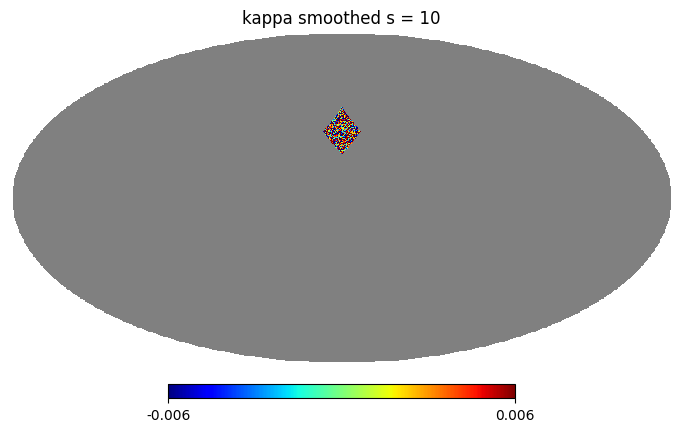

In [30]:
ell2, cl2 = patch_power(kappa[start_idx:end_idx], start_idx-base_pix, end_idx-base_pix, nside)

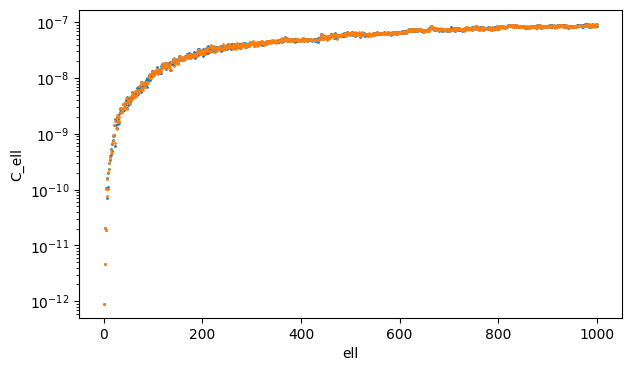

In [31]:
# plot the cl
fig = plt.figure(figsize=(7, 4))
plt.scatter(ell, cl * ell * (ell + 1) / 2. / np.pi, s=1)
plt.scatter(ell2, cl2 * ell2 * (ell2 + 1) / 2. / np.pi, s=1)
plt.yscale('log')
plt.xlabel('ell')
plt.ylabel('C_ell')
plt.show()

In [201]:

center = hp.pix2ang(hp.get_nside(kappa), pix_offset + 3 * base_pix// 4, nest=True, lonlat=True)

In [190]:
kappa_patch = kappa_nested.copy()
kappa_patch[:pix_offset] = hp.UNSEEN
kappa_patch[pix_offset +  base_pix:] = hp.UNSEEN
kappa_patch = hp.reorder(kappa_patch, n2r=True)
kappa_patch = hp.ma(kappa_patch)

kappa_smoothed_patch = kappa_smoothed_nested.copy()
kappa_smoothed_patch[:pix_offset] = hp.UNSEEN
kappa_smoothed_patch[pix_offset + base_pix:] = hp.UNSEEN
kappa_smoothed_patch = hp.reorder(kappa_smoothed_patch, n2r=True)
kappa_smoothed_patch = hp.ma(kappa_smoothed_patch)

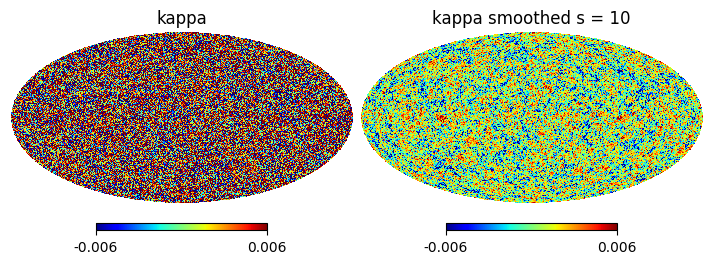

In [170]:
# plot the data
fig = plt.figure(figsize=(7, 4))
hp.mollview(kappa_nested, title='kappa', sub=(1, 2, 1), min=-0.006, max=0.006, cmap='jet', nest=True)
hp.mollview(kappa_smoothed_nested, title='kappa smoothed s = 10', sub=(1, 2, 2), min=-0.006, max=0.006, cmap='jet', nest=True)
plt.show()

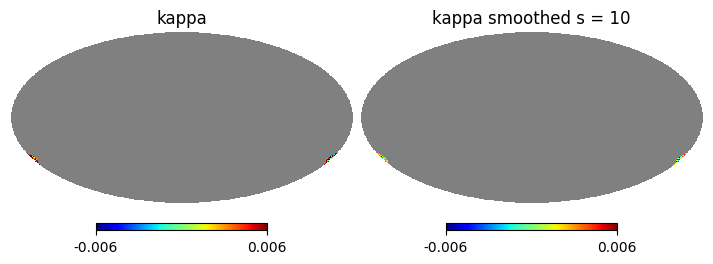

In [191]:
fig = plt.figure(figsize=(7, 4))
hp.mollview(kappa_patch, title='kappa', sub=(1, 2, 1), min=-0.006, max=0.006, cmap='jet')
hp.mollview(kappa_smoothed_patch, title='kappa smoothed s = 10', sub=(1, 2, 2), min=-0.006, max=0.006, cmap='jet')
plt.show()

# Full Sky

## PDF

In [6]:
def run_PDF(map1_smooth, fname, dir_results='/lustre/work/akira.tokiwa/Projects/LensingSSC/results/test'):    
        dir_PDF = os.path.join(dir_results, 'PDF')
        os.makedirs(dir_PDF, exist_ok=True)
        fn_out_counts = os.path.basename(fname).replace('.fits', '_Counts_kappa_width0.1_200Kappabins.dat')

        if os.path.exists(os.path.join(dir_PDF, fn_out_counts)):
            counts_smooth = np.loadtxt(os.path.join(dir_PDF, fn_out_counts))
        else:
                # Calculate histogram
                bins = np.linspace(-0.1 - 0.001, 0.1 + 0.001, 201)
                counts_smooth, _ = np.histogram(map1_smooth, density=True, bins=bins)
                np.savetxt(os.path.join(dir_PDF, fn_out_counts), counts_smooth)
        return counts_smooth, os.path.join(dir_PDF, fn_out_counts)

In [7]:
def plot_PDF(data_file, fname, dir_img='/lustre/work/akira.tokiwa/Projects/LensingSSC/img/test'):
    # Plot the PDF
    bins = np.linspace(-0.1, 0.1, 200)
    counts = np.loadtxt(data_file)
    plt.figure(figsize=(7, 4))
    plt.plot(bins, counts, drawstyle='steps-post')
    plt.xlabel('Kappa')
    plt.ylabel('Probability Density')

    dataname = os.path.basename(fname).replace('.fits', '')
    plt.title(f'PDF of {dataname}')
    plt.grid(True)

    # Save the figure
    output_file = os.path.basename(fname).replace('.fits', '_PDF.png')
    plt.savefig(os.path.join(dir_img, output_file), bbox_inches='tight')

    # Show the plot
    plt.show()

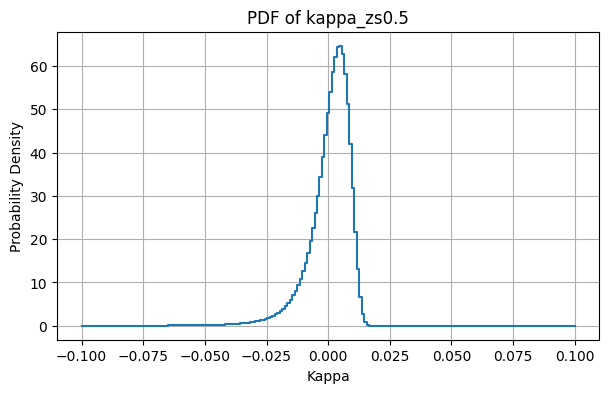

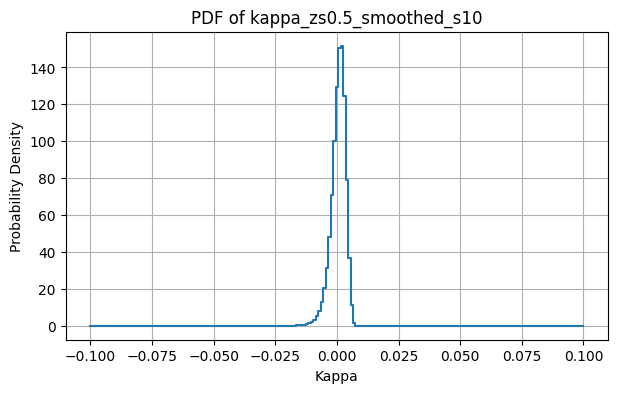

In [8]:
base_PDF, base_PDF_path = run_PDF(kappa, path)
smoothed_PDF, smoothed_PDF_path = run_PDF(kappa_smoothed, smoothed_path)
plot_PDF(base_PDF_path, path)
plot_PDF(smoothed_PDF_path, smoothed_path)

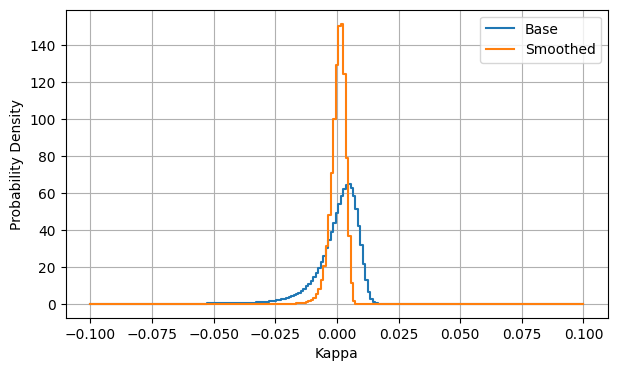

In [9]:
bins = np.linspace(-0.1, 0.1, 200)
plt.figure(figsize=(7, 4))
plt.plot(bins, base_PDF, drawstyle='steps-post', label='Base')
plt.plot(bins, smoothed_PDF, drawstyle='steps-post', label='Smoothed')
plt.xlabel('Kappa')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


## Peaks_minima

In [8]:
import multiprocessing as mp

def find_extrema_worker(pixel_val, neighbour_vals, minima=False):
    if minima:
        return np.all(np.tile(pixel_val, [8, 1]).T < neighbour_vals, axis=-1)
    else:
        return np.all(np.tile(pixel_val, [8, 1]).T > neighbour_vals, axis=-1)

def find_extrema(kappa_map, minima=False, lonlat=False):
    # First create an array of all neighbours for all valid healsparse pixels
    nside = hp.get_nside(kappa_map) # get nside
    ipix = np.arange(hp.nside2npix(nside))[kappa_map.mask == False] # list all pixels and remove masked ones
    neighbours = hp.get_all_neighbours(nside, ipix) # find neighbours for all pixels we care about

    # Get kappa values for each pixel in the neighbour array
    neighbour_vals = kappa_map.data[neighbours.T]
    # Get kappa values for all valid healsparse pixels
    pixel_val = kappa_map.data[ipix]

    with mp.Pool(processes=mp.cpu_count()) as pool:
        # Start the parallel computation
        extrema = pool.starmap_async(
            find_extrema_worker, 
            [(pixel_val[i], neighbour_vals[i], minima) for i in range(len(pixel_val))]
        ).get()

    extrema = np.array(extrema)[:,0]
    # Print the number of extrema identified
    if minima:
        print(f'number of minima identified: {np.where(extrema)[0].shape[0]}')
    else:
        print(f'number of peaks identified: {np.where(extrema)[0].shape[0]}')

    extrema_pos = np.asarray(hp.pix2ang(nside, ipix[extrema], lonlat=lonlat)).T # find the extrema positions
    extrema_amp = kappa_map[ipix][extrema].data # find the extrema amplitudes
    
    return extrema_pos, extrema_amp

In [40]:
def run_extrema(map1_smooth, fname, minima=False, dir_results='/lustre/work/akira.tokiwa/Projects/LensingSSC/results/test'):
    dir_peaks = os.path.join(dir_results, 'peaks') if not minima else os.path.join(dir_results, 'minima')
    os.makedirs(dir_peaks, exist_ok=True)
    fn_out_peaks =  os.path.basename(fname).replace('.fits',  f'_peaks_posRADEC_amp.dat') if not minima else os.path.basename(fname).replace('.fits',  f'_minima_posRADEC_amp.dat')

    if os.path.exists(os.path.join(dir_peaks, fn_out_peaks)):
        peaks = np.loadtxt(os.path.join(dir_peaks, fn_out_peaks))
    else:
        peak_pos, peak_amp = find_extrema(map1_smooth, lonlat=True) if not minima else find_extrema(map1_smooth, lonlat=True, minima=True)
        peaks = np.vstack([peak_pos.T, peak_amp]).T
        np.savetxt(os.path.join(dir_peaks, fn_out_peaks), peaks)
    return peaks, os.path.join(dir_peaks, fn_out_peaks)

In [209]:
base_peaks, base_peaks_path = run_extrema(kappa_patch, path)
base_minima, base_minima_path = run_extrema(kappa_patch, path, minima=True)

smoothed_peaks, smoothed_peaks_path = run_extrema(kappa_smoothed_patch, smoothed_path)
smoothed_minima, smoothed_minima_path = run_extrema(kappa_smoothed_patch, smoothed_path, minima=True)

number of peaks identified: 101707
number of minima identified: 100449
number of peaks identified: 73
number of minima identified: 60


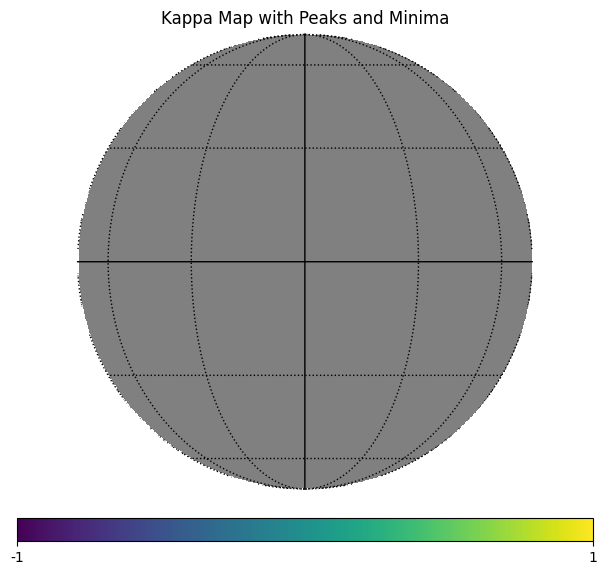

In [211]:
fig = plt.figure(figsize=(12, 6))
hp.orthview(kappa_smoothed_patch, title='Kappa Map with Peaks and Minima', half_sky=True, fig=fig)
hp.projscatter(smoothed_peaks.T[:2,:],marker = '.',s=0.5,color='red',lonlat=True, label='Peaks')
hp.projscatter(smoothed_minima.T[:2,:],marker = '.',s=0.5,color='yellow',lonlat=True, label='Minima')
hp.graticule()

In [229]:
proj.xy2ang(350, 350, lonlat=True)

array([120.3520786 ,  34.97347651])

In [228]:
proj.ang2xy([180. , -35.67959427], lonlat=True)

(-5.375084318041341e-34, 3.0740362378941214e-11)

In [225]:
smoothed_peaks.T[:2, :]

array([[180.        , 179.74731445, 180.37353516, 179.16503906,
        180.05493164, 180.55480957, 178.69812012, 179.49462891,
        181.32385254, 181.3293457 , 181.43920898, 178.50585938,
        182.27416992, 179.07714844, 180.63720703, 177.43469238,
        183.05419922, 180.65368652, 179.28039551, 183.55957031,
        181.14257812, 180.97229004, 179.90112305, 176.3470459 ,
        182.91137695, 184.15283203, 183.38928223, 181.63146973,
        184.43847656, 177.05566406, 179.73632812, 180.95031738,
        175.37475586, 178.54980469, 185.09765625, 182.39501953,
        179.35180664, 184.70214844, 180.73608398, 174.81445312,
        183.49365234, 181.13708496, 185.46020508, 176.57226562,
        178.47290039, 181.6809082 , 184.39453125, 175.92407227,
        175.18249512, 177.87963867, 182.92785645, 179.04418945,
        177.08312988, 183.98803711, 180.59326172, 178.29162598,
        176.20422363, 177.71484375, 182.69714355, 176.63818359,
        178.84643555, 181.20849609, 179.

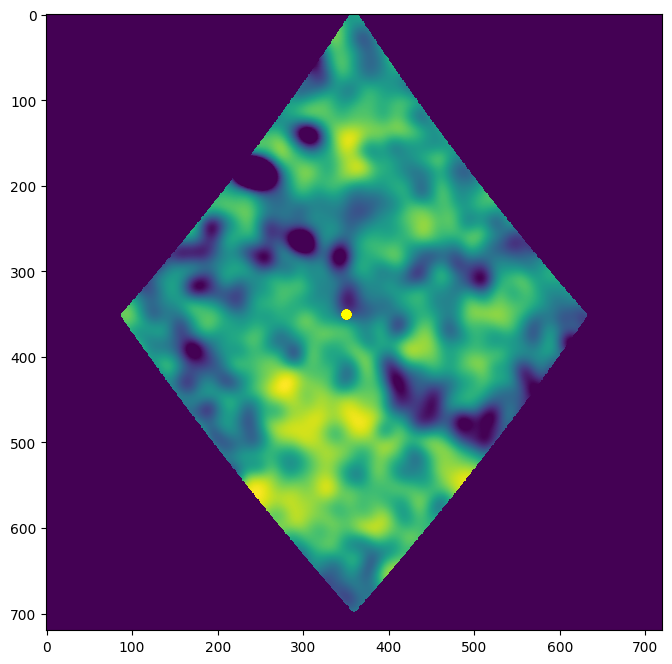

In [231]:
# Define the gnomonic projection
proj = hp.projector.GnomonicProj(rot=center,xsize=720, ysize=720, reso=1)

# Project the Healpix map onto a 2D plane
kappa_map_2d = proj.projmap(kappa_smoothed_patch, lambda x, y, z: hp.vec2pix(hp.get_nside(kappa_smoothed_patch), x, y, z))
kappa_map_2d = np.ma.masked_invalid(kappa_map_2d)

peaks_2d = proj.ang2xy(smoothed_peaks.T[0], smoothed_peaks.T[1], lonlat=True)
minima_2d = proj.ang2xy(smoothed_minima.T[0], smoothed_minima.T[1], lonlat=True)

# Plot the 2D map
plt.figure(figsize=(10, 8))
plt.imshow(kappa_map_2d, cmap='viridis', vmin=-0.006, vmax=0.006)
plt.scatter(peaks_2d[0]+350, peaks_2d[1]+350, c='red', label='Peaks')
plt.scatter(minima_2d[0]+350, minima_2d[1]+350, c='yellow', label='Minima')
plt.show()

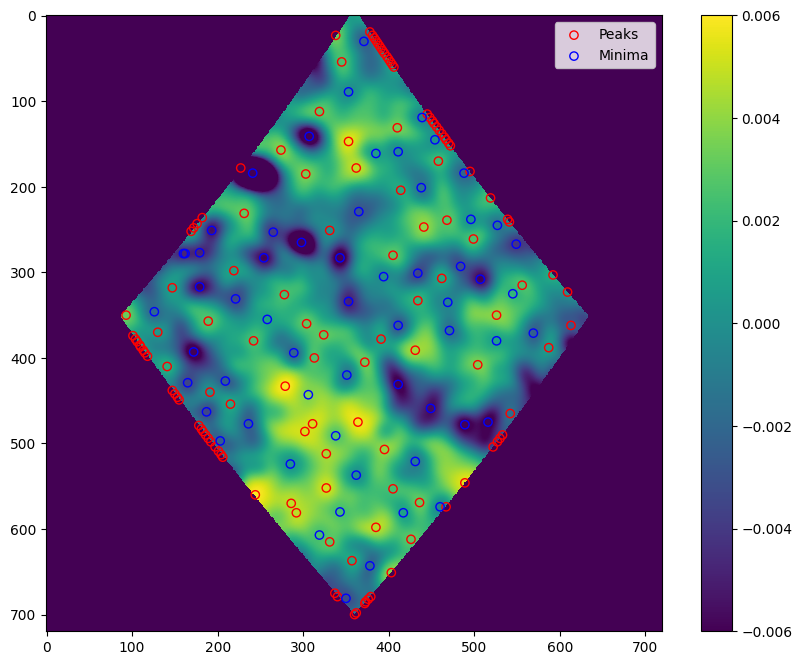

In [208]:
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter
import matplotlib.pyplot as plt

# Assuming 'data' is your 2D numpy array of shape (600, 600)
# Load your data here, for example using np.loadtxt or similar methods.

# Example: data = np.loadtxt('path_to_your_data.txt')
data = kappa_map_2d  

# Apply the maximum and minimum filters
neighborhood_size = 3
local_max = maximum_filter(data, size=neighborhood_size, mode='constant')
local_min = minimum_filter(data, size=neighborhood_size, mode='constant')

# Identify peaks and minima
peaks = (data == local_max) & (data > np.roll(data, 1, axis=0)) & (data > np.roll(data, -1, axis=0)) & \
        (data > np.roll(data, 1, axis=1)) & (data > np.roll(data, -1, axis=1))


minima = (data == local_min) & (data < np.roll(data, 1, axis=0)) & (data < np.roll(data, -1, axis=0)) & \
         (data < np.roll(data, 1, axis=1)) & (data < np.roll(data, -1, axis=1))

# Exclude edges by setting edge peaks and minima to False
peaks[:1, :] = peaks[-1:, :] = peaks[:, :1] = peaks[:, -1:] = False
minima[:1, :] = minima[-1:, :] = minima[:, :1] = minima[:, -1:] = False

# Exclude peaks and minima where any neighbor is masked
mask = data.mask
for i in range(1, data.shape[0] - 1):
    for j in range(1, data.shape[1] - 1):
        if mask[i-1:i+2, j-1:j+2].any():
            peaks[i, j] = False
            minima[i, j] = False

# Plot the results
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='viridis', vmin=-0.006, vmax=0.006)
plt.colorbar()

# Overlay peaks and minima with circles
plt.scatter(np.where(peaks)[1], np.where(peaks)[0], facecolors='none', edgecolors='red', label='Peaks')
plt.scatter(np.where(minima)[1], np.where(minima)[0], facecolors='none', edgecolors='blue', label='Minima')

plt.legend()
plt.show()



In [56]:
kappa_patch = hp.ma(kappa_smoothed)
base_pix = 256

# mask out the pixels outside the patch
kappa_patch.mask = np.zeros(kappa_patch.mask.shape, dtype=bool)
kappa_patch.mask[9*base_pix**2:10*base_pix**2] = True

In [106]:
# Define the gnomonic projection
proj = hp.projector.GnomonicProj(xsize=600, ysize=600, reso=1)
# Project the Healpix map onto a 2D plane
kappa_map_2d = proj.projmap(kappa_patch, lambda x, y, z: hp.vec2pix(hp.get_nside(kappa_patch), x, y, z))
# Mask out invalid values
kappa_map_2d = np.ma.masked_invalid(kappa_map_2d)

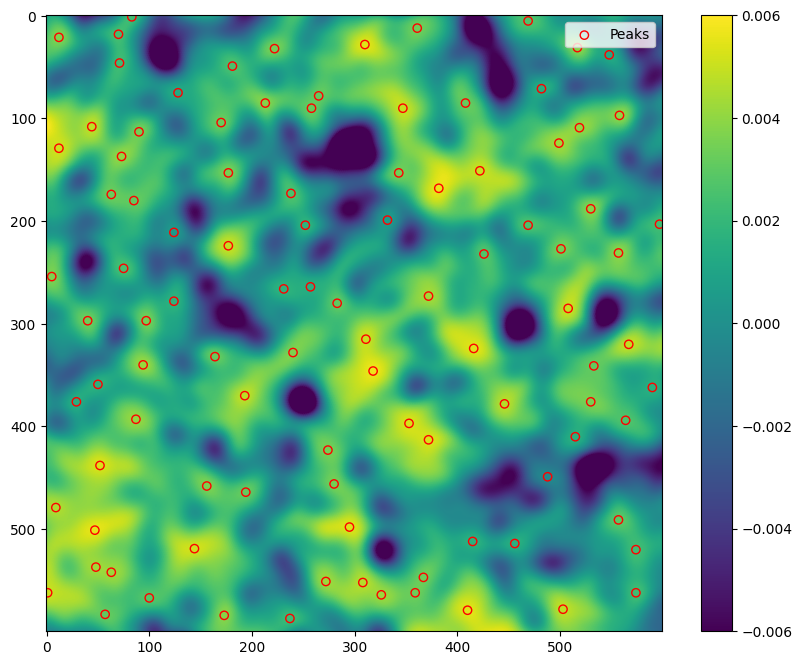

In [61]:
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter
import matplotlib.pyplot as plt

# Assuming 'data' is your 2D numpy array of shape (600, 600)
# Load your data here, for example using np.loadtxt or similar methods.

# Example: data = np.loadtxt('path_to_your_data.txt')
data = kappa_map_2d.data

# Apply the maximum and minimum filters
neighborhood_size = 3
local_max = maximum_filter(data, size=neighborhood_size, mode='constant')
local_min = minimum_filter(data, size=neighborhood_size, mode='constant')

# Identify peaks and minima
peaks = (data == local_max) & (data > np.roll(data, 1, axis=0)) & (data > np.roll(data, -1, axis=0)) & \
        (data > np.roll(data, 1, axis=1)) & (data > np.roll(data, -1, axis=1))

minima = (data == local_min) & (data < np.roll(data, 1, axis=0)) & (data < np.roll(data, -1, axis=0)) & \
         (data < np.roll(data, 1, axis=1)) & (data < np.roll(data, -1, axis=1))

# Exclude edges by setting edge peaks and minima to False
peaks[:1, :] = peaks[-1:, :] = peaks[:, :1] = peaks[:, -1:] = False
minima[:1, :] = minima[-1:, :] = minima[:, :1] = minima[:, -1:] = False

# Plot the results
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='viridis', vmin=-0.006, vmax=0.006)
plt.colorbar()

# Overlay peaks and minima with circles
plt.scatter(np.where(peaks)[1], np.where(peaks)[0], facecolors='none', edgecolors='red', label='Peaks')
#plt.scatter(np.where(minima)[1], np.where(minima)[0], facecolors='none', edgecolors='blue', label='Minima')

plt.legend()
plt.show()
